In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/game-of-deep-learning-ship-datasets/test_ApKoW4T.csv
/kaggle/input/game-of-deep-learning-ship-datasets/sample_submission_ns2btKE.csv
/kaggle/input/game-of-deep-learning-ship-datasets/train/train.csv
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2213022.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2842076.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2862031.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2880224.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2821082.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2833446.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2847421.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2851911.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2794325.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/725088.jpg
/kaggle/input/game-of-deep-learning-sh

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

2025-10-03 12:20:41.254484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759494041.497369      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759494041.567938      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
df = pd.read_csv('/kaggle/input/game-of-deep-learning-ship-datasets/train/train.csv')
df.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [5]:
df.columns

Index(['image', 'category'], dtype='object')

Total images: 6252
Categories: [1 2 3 4 5]


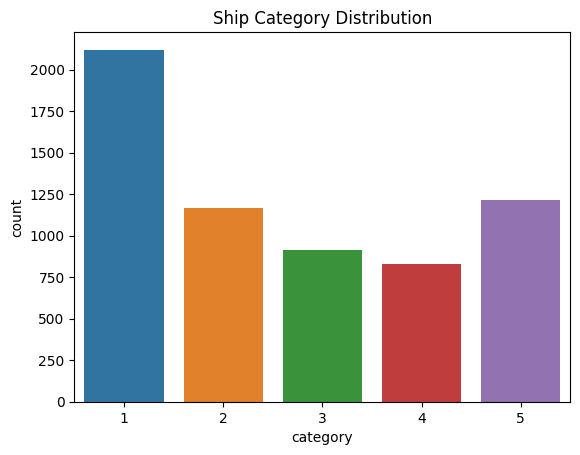

In [6]:
print('Total images:', len(df))
print('Categories:', df['category'].unique())

# Plot class distribution
sns.countplot(data=df, x='category')
plt.title('Ship Category Distribution')
plt.show()

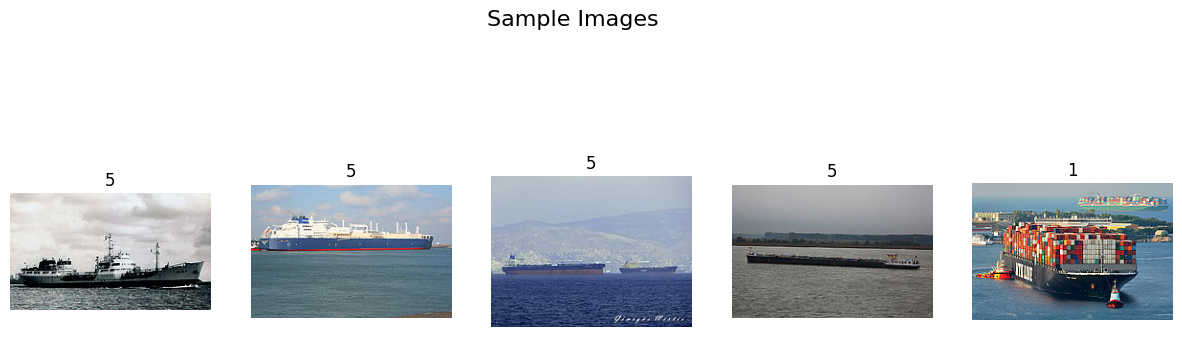

In [7]:
# Show 5 random images
img_path = '/kaggle/input/game-of-deep-learning-ship-datasets/train/images/'
sample = df.sample(5)

plt.figure(figsize=(15,5))
for i, row in enumerate(sample.values):
    img = Image.open(img_path + row[0])
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(row[1])
    plt.axis('off')
plt.suptitle("Sample Images", fontsize=16)
plt.show()

In [8]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the CSV
df = pd.read_csv('/kaggle/input/game-of-deep-learning-ship-datasets/train/train.csv')

# Convert category column to string
df['category'] = df['category'].astype(str)

# Add full image path
img_path = '/kaggle/input/game-of-deep-learning-ship-datasets/train/images/'
df['image'] = img_path + df['image']

# Train-validation split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['category'], random_state=42)

# ImageDataGenerator with augmentations
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             zoom_range=0.2,
                             horizontal_flip=True)

# Training generator
train_gen = datagen.flow_from_dataframe(train_df,
                                        x_col='image',
                                        y_col='category',
                                        target_size=(224, 224),
                                        class_mode='categorical',
                                        batch_size=32)

# Validation generator
val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    val_df,
    x_col='image',
    y_col='category',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32)

Found 5001 validated image filenames belonging to 5 classes.
Found 1251 validated image filenames belonging to 5 classes.


In [9]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# EfficientNetB0 as base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Get the number of classes
num_classes = len(train_gen.class_indices)

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Corrected here
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()

2025-10-03 12:21:02.439563: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [10]:
history = model.fit(train_gen, validation_data=val_gen, epochs=5)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.3256 - loss: 1.5677 - val_accuracy: 0.3389 - val_loss: 1.5615
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.3377 - loss: 1.5578 - val_accuracy: 0.3389 - val_loss: 1.5541
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.3390 - loss: 1.5547 - val_accuracy: 0.3389 - val_loss: 1.5676
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.3339 - loss: 1.5611 - val_accuracy: 0.3389 - val_loss: 1.5544
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.3337 - loss: 1.5557 - val_accuracy: 0.3389 - val_loss: 1.5502


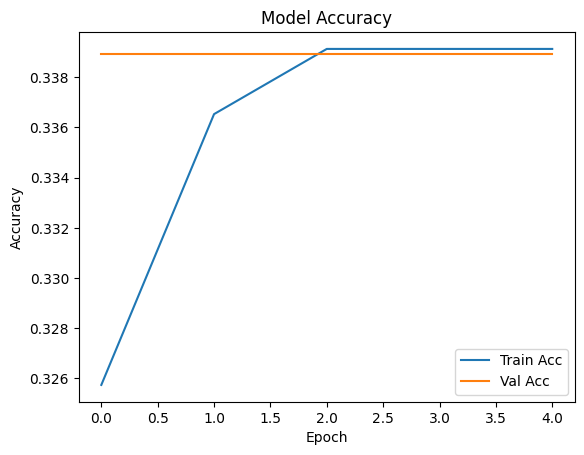

In [11]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


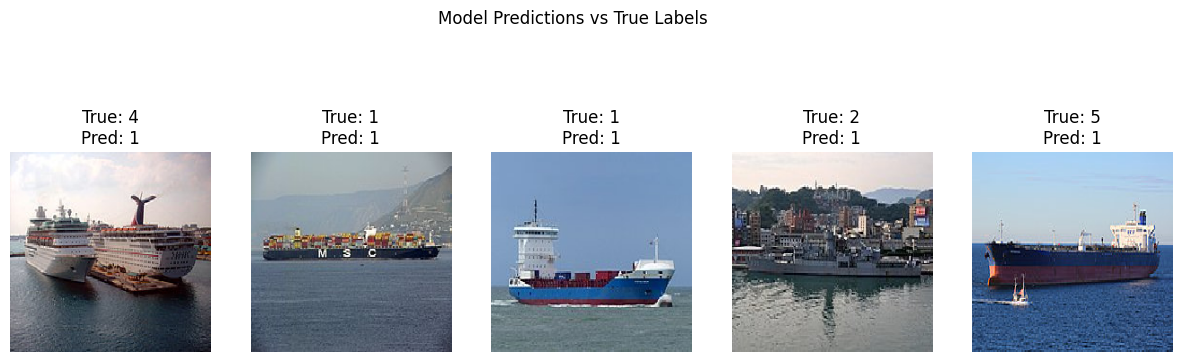

In [12]:
# Get some images and predictions
imgs, labels = next(val_gen)
preds = model.predict(imgs)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(labels, axis=1)
class_names = list(val_gen.class_indices.keys())

# Plot
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(imgs[i])
    plt.title(f'True: {class_names[true_classes[i]]}\nPred: {class_names[pred_classes[i]]}')
    plt.axis('off')
plt.suptitle("Model Predictions vs True Labels")
plt.show()